### Modelo base

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Dados MNIST
transform = transforms.ToTensor()
train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000)

# Modelo
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)


### Treinamento com CrossEntropyLoss

In [5]:
model_ce = Net()
loss_ce = nn.CrossEntropyLoss()
optimizer_ce = optim.Adam(model_ce.parameters(), lr=0.001)

for epoch in range(5):
    correct, total = 0, 0
    for images, labels in train_loader:
        outputs = model_ce(images)
        loss = loss_ce(outputs, labels)

        optimizer_ce.zero_grad()
        loss.backward()
        optimizer_ce.step()

        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    acc = correct / total
    print(f'[CE] Época {epoch+1}, Acurácia: {acc*100:.2f}%')


[CE] Época 1, Acurácia: 90.64%
[CE] Época 2, Acurácia: 95.47%
[CE] Época 3, Acurácia: 96.78%
[CE] Época 4, Acurácia: 97.50%
[CE] Época 5, Acurácia: 98.05%


### Treinamento com MSELoss

In [7]:
# One-hot encoding dos labels
def to_onehot(labels, num_classes=10):
    return torch.eye(num_classes)[labels]

model_mse = Net()
loss_mse = nn.MSELoss()
optimizer_mse = optim.Adam(model_mse.parameters(), lr=0.001)

for epoch in range(5):
    correct, total = 0, 0
    for images, labels in train_loader:
        one_hot = to_onehot(labels).float()

        outputs = model_mse(images)
        loss = loss_mse(outputs, one_hot)

        optimizer_mse.zero_grad()
        loss.backward()
        optimizer_mse.step()

        preds = torch.argmax(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    acc = correct / total
    print(f'[MSE] Época {epoch+1}, Acurácia: {acc*100:.2f}%')


[MSE] Época 1, Acurácia: 92.98%
[MSE] Época 2, Acurácia: 96.57%
[MSE] Época 3, Acurácia: 97.25%
[MSE] Época 4, Acurácia: 97.54%
[MSE] Época 5, Acurácia: 97.80%


In [ ]:
### nova funcao de custo

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EntropyEnergyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs, targets):
        """
        outputs: [batch_size, num_classes] - logits
        targets: [batch_size] - rótulos (como inteiros, 0 a 9)
        """
        # Convertendo para "energia positiva"
        energies = torch.exp(outputs)  # simula energia -> maior logit = mais energia

        # Energia total (somando todas as classes)
        total_energy = torch.sum(energies, dim=1)

        # Energia da classe correta
        correct_energy = energies[range(outputs.size(0)), targets]

        # Razão de energia dissipada na classe correta (quanto menor, melhor)
        loss = correct_energy / total_energy  # queremos isso o menor possível

        # Penalidade final: queremos minimizar a energia da classe correta relativa à total
        return torch.mean(1 - loss)  # quanto mais próximo de 0, menor a energia dissipada


In [14]:
loss_fn_energy = EntropyEnergyLoss()
loss = loss_fn_energy(outputs, labels)



Treinando com CrossEntropyLoss...
Época 1 | Loss: 0.3480 | Acurácia: 90.48%
Época 2 | Loss: 0.1561 | Acurácia: 95.45%
Época 3 | Loss: 0.1063 | Acurácia: 96.91%
Época 4 | Loss: 0.0801 | Acurácia: 97.64%
Época 5 | Loss: 0.0634 | Acurácia: 98.11%
Época 6 | Loss: 0.0516 | Acurácia: 98.47%
Época 7 | Loss: 0.0423 | Acurácia: 98.76%
Época 8 | Loss: 0.0349 | Acurácia: 98.97%
Época 9 | Loss: 0.0280 | Acurácia: 99.21%
Época 10 | Loss: 0.0238 | Acurácia: 99.28%
Época 11 | Loss: 0.0201 | Acurácia: 99.43%
Época 12 | Loss: 0.0170 | Acurácia: 99.53%
Época 13 | Loss: 0.0133 | Acurácia: 99.67%
Época 14 | Loss: 0.0123 | Acurácia: 99.68%
Época 15 | Loss: 0.0094 | Acurácia: 99.76%
Época 16 | Loss: 0.0091 | Acurácia: 99.77%
Época 17 | Loss: 0.0074 | Acurácia: 99.84%
Época 18 | Loss: 0.0066 | Acurácia: 99.83%
Época 19 | Loss: 0.0063 | Acurácia: 99.84%
Época 20 | Loss: 0.0051 | Acurácia: 99.90%

Treinando com EntropyEnergyLoss (baseada em energia)...
Época 1 | Loss: 0.1517 | Acurácia: 87.97%
Época 2 | Loss:

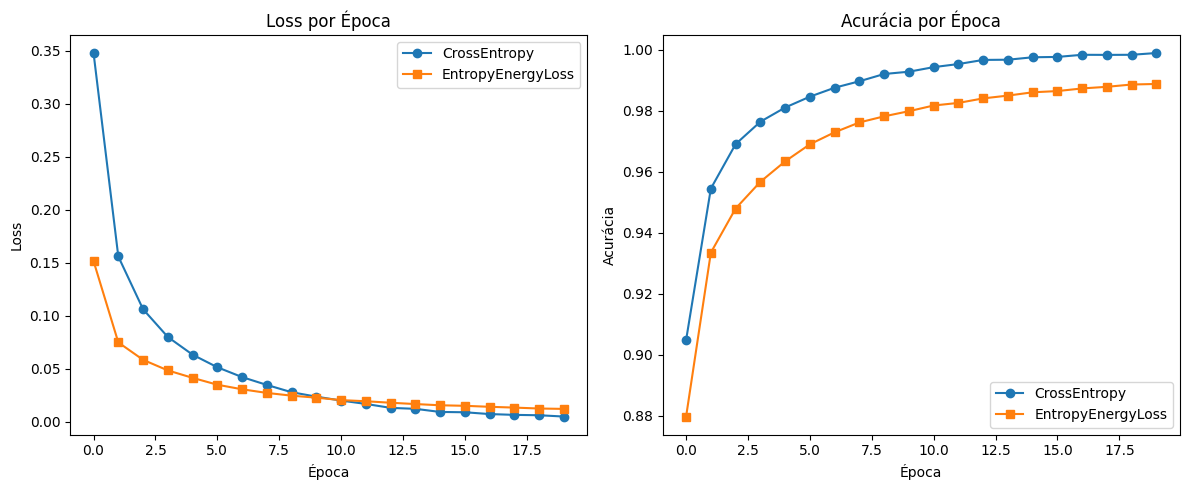

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Dataset MNIST
transform = transforms.ToTensor()
train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Modelo base
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

# Função de perda baseada em "energia dissipada"
class EntropyEnergyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs, targets):
        energies = torch.exp(outputs)  # transforma logits em energias
        total_energy = torch.sum(energies, dim=1)
        correct_energy = energies[range(outputs.size(0)), targets]
        loss = correct_energy / total_energy  # queremos isso o menor possível
        return torch.mean(1 - loss)  # perda → 0 quando energia correta é dominante

# Função de treinamento
def train(model, loss_fn, optimizer, epochs=20):
    loss_list, acc_list = [], []

    for epoch in range(epochs):
        total_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        loss_list.append(avg_loss)
        acc_list.append(accuracy)
        print(f"Época {epoch+1} | Loss: {avg_loss:.4f} | Acurácia: {accuracy*100:.2f}%")

    return loss_list, acc_list

# Treinamento com CrossEntropyLoss
print("\nTreinando com CrossEntropyLoss...")
model_ce = Net()
loss_fn_ce = nn.CrossEntropyLoss()
optimizer_ce = optim.Adam(model_ce.parameters(), lr=0.001)
loss_ce, acc_ce = train(model_ce, loss_fn_ce, optimizer_ce)

# Treinamento com EntropyEnergyLoss
print("\nTreinando com EntropyEnergyLoss (baseada em energia)...")
model_energy = Net()
loss_fn_energy = EntropyEnergyLoss()
optimizer_energy = optim.Adam(model_energy.parameters(), lr=0.001)
loss_energy, acc_energy = train(model_energy, loss_fn_energy, optimizer_energy)

# Plotar comparação
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_ce, label='CrossEntropy', marker='o')
plt.plot(loss_energy, label='EntropyEnergyLoss', marker='s')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_ce, label='CrossEntropy', marker='o')
plt.plot(acc_energy, label='EntropyEnergyLoss', marker='s')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()



Treinando com CrossEntropyLoss...
Época 1 | Loss: 0.3454 | Acurácia: 90.74%
Época 2 | Loss: 0.1576 | Acurácia: 95.41%
Época 3 | Loss: 0.1090 | Acurácia: 96.81%
Época 4 | Loss: 0.0817 | Acurácia: 97.56%
Época 5 | Loss: 0.0641 | Acurácia: 98.08%

Treinando com EntropyEnergyLoss (energia dissipada)...
Época 1 | Loss: 0.2069 | Acurácia: 82.12%
Época 2 | Loss: 0.0742 | Acurácia: 93.56%
Época 3 | Loss: 0.0559 | Acurácia: 95.07%
Época 4 | Loss: 0.0459 | Acurácia: 95.96%
Época 5 | Loss: 0.0385 | Acurácia: 96.64%

Treinando com BoltzmannEnergyLoss (temperatura=0.5)...
Época 1 | Loss: -14618.4035 | Acurácia: 9.91%
Época 2 | Loss: -99155.5004 | Acurácia: 9.92%
Época 3 | Loss: -249722.4558 | Acurácia: 9.92%
Época 4 | Loss: -453229.2844 | Acurácia: 9.92%
Época 5 | Loss: -702323.8556 | Acurácia: 9.92%


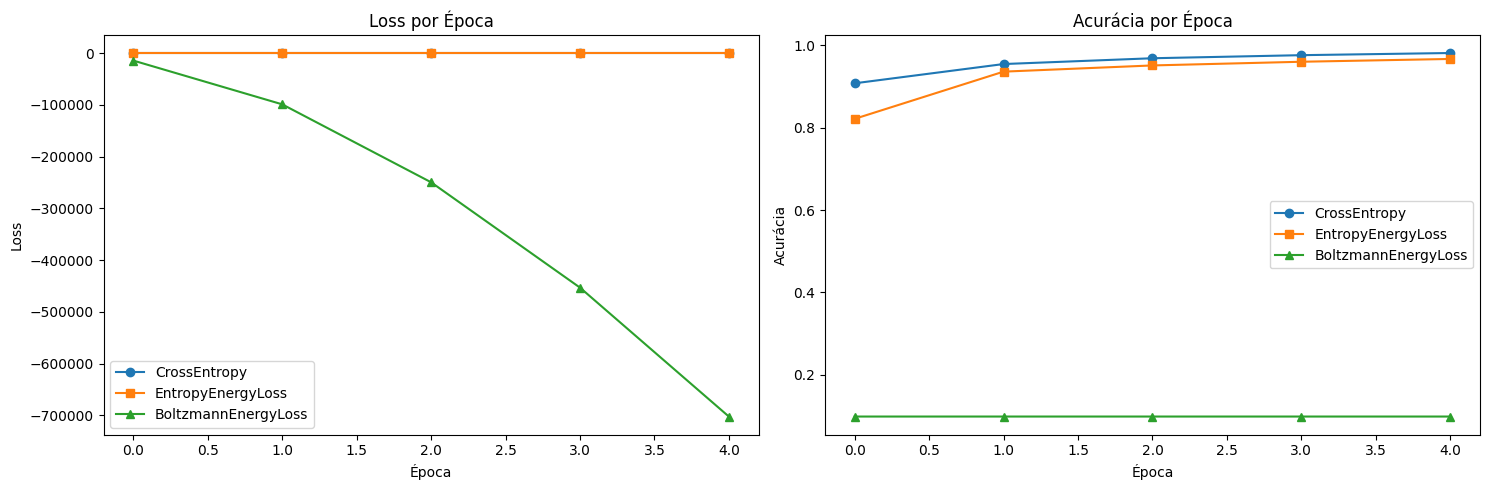

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Dataset MNIST
transform = transforms.ToTensor()
train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Modelo base
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

# Função de perda EntropyEnergyLoss (energia dissipada)
class EntropyEnergyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs, targets):
        energies = torch.exp(outputs)  # transforma logits em energias
        total_energy = torch.sum(energies, dim=1)
        correct_energy = energies[range(outputs.size(0)), targets]
        loss = correct_energy / total_energy  # queremos isso o menor possível
        return torch.mean(1 - loss)  # perda → 0 quando energia correta é dominante

# Função de perda BoltzmannEnergyLoss (generalizada com temperatura)
class BoltzmannEnergyLoss(nn.Module):
    def __init__(self, temperature=1.0):
        super().__init__()
        self.T = temperature

    def forward(self, outputs, targets):
        energies = -outputs  # energia: maior logit = menor energia
        weights = torch.softmax(-energies / self.T, dim=1)  # p_i = exp(-E_i/T) / Z
        mean_energy = torch.sum(weights * energies, dim=1)
        correct_energy = energies[torch.arange(outputs.size(0)), targets]
        loss = mean_energy - correct_energy
        return loss.mean()

# Função de treinamento
def train(model, loss_fn, optimizer, epochs=5):
    loss_list, acc_list = [], []

    for epoch in range(epochs):
        total_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        loss_list.append(avg_loss)
        acc_list.append(accuracy)
        print(f"Época {epoch+1} | Loss: {avg_loss:.4f} | Acurácia: {accuracy*100:.2f}%")

    return loss_list, acc_list

# Treinamento CrossEntropyLoss
print("\nTreinando com CrossEntropyLoss...")
model_ce = Net()
loss_fn_ce = nn.CrossEntropyLoss()
optimizer_ce = optim.Adam(model_ce.parameters(), lr=0.001)
loss_ce, acc_ce = train(model_ce, loss_fn_ce, optimizer_ce)

# Treinamento EntropyEnergyLoss
print("\nTreinando com EntropyEnergyLoss (energia dissipada)...")
model_energy = Net()
loss_fn_energy = EntropyEnergyLoss()
optimizer_energy = optim.Adam(model_energy.parameters(), lr=0.001)
loss_energy, acc_energy = train(model_energy, loss_fn_energy, optimizer_energy)

# Treinamento BoltzmannEnergyLoss
print("\nTreinando com BoltzmannEnergyLoss (temperatura=0.5)...")
model_boltz = Net()
loss_fn_boltz = BoltzmannEnergyLoss(temperature=0.5)
optimizer_boltz = optim.Adam(model_boltz.parameters(), lr=0.001)
loss_boltz, acc_boltz = train(model_boltz, loss_fn_boltz, optimizer_boltz)

# Plot comparação
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_ce, label='CrossEntropy', marker='o')
plt.plot(loss_energy, label='EntropyEnergyLoss', marker='s')
plt.plot(loss_boltz, label='BoltzmannEnergyLoss', marker='^')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_ce, label='CrossEntropy', marker='o')
plt.plot(acc_energy, label='EntropyEnergyLoss', marker='s')
plt.plot(acc_boltz, label='BoltzmannEnergyLoss', marker='^')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()



Treinando com CrossEntropyLoss...
Época 1 | Loss: 0.3498 | Acurácia: 90.45%
Época 2 | Loss: 0.1553 | Acurácia: 95.54%
Época 3 | Loss: 0.1065 | Acurácia: 96.89%
Época 4 | Loss: 0.0810 | Acurácia: 97.59%
Época 5 | Loss: 0.0654 | Acurácia: 98.00%

Treinando com EntropyEnergyLoss (energia dissipada)...
Época 1 | Loss: 0.1504 | Acurácia: 88.40%
Época 2 | Loss: 0.0710 | Acurácia: 93.77%
Época 3 | Loss: 0.0561 | Acurácia: 95.03%
Época 4 | Loss: 0.0467 | Acurácia: 95.81%
Época 5 | Loss: 0.0397 | Acurácia: 96.47%

Treinando com BoltzmannEnergyLoss (temperatura=0.5)...
Época 1 | Loss: -12574.9509 | Acurácia: 9.80%
Época 2 | Loss: -87652.8171 | Acurácia: 9.87%
Época 3 | Loss: -223793.5852 | Acurácia: 9.87%
Época 4 | Loss: -408851.2333 | Acurácia: 9.87%
Época 5 | Loss: -636084.7446 | Acurácia: 9.87%

Treinando com BoltzmannCrossEntropyLoss (temperatura=0.5)...
Época 1 | Loss: 0.2957 | Acurácia: 91.65%
Época 2 | Loss: 0.1298 | Acurácia: 96.24%
Época 3 | Loss: 0.0898 | Acurácia: 97.30%
Época 4 | Lo

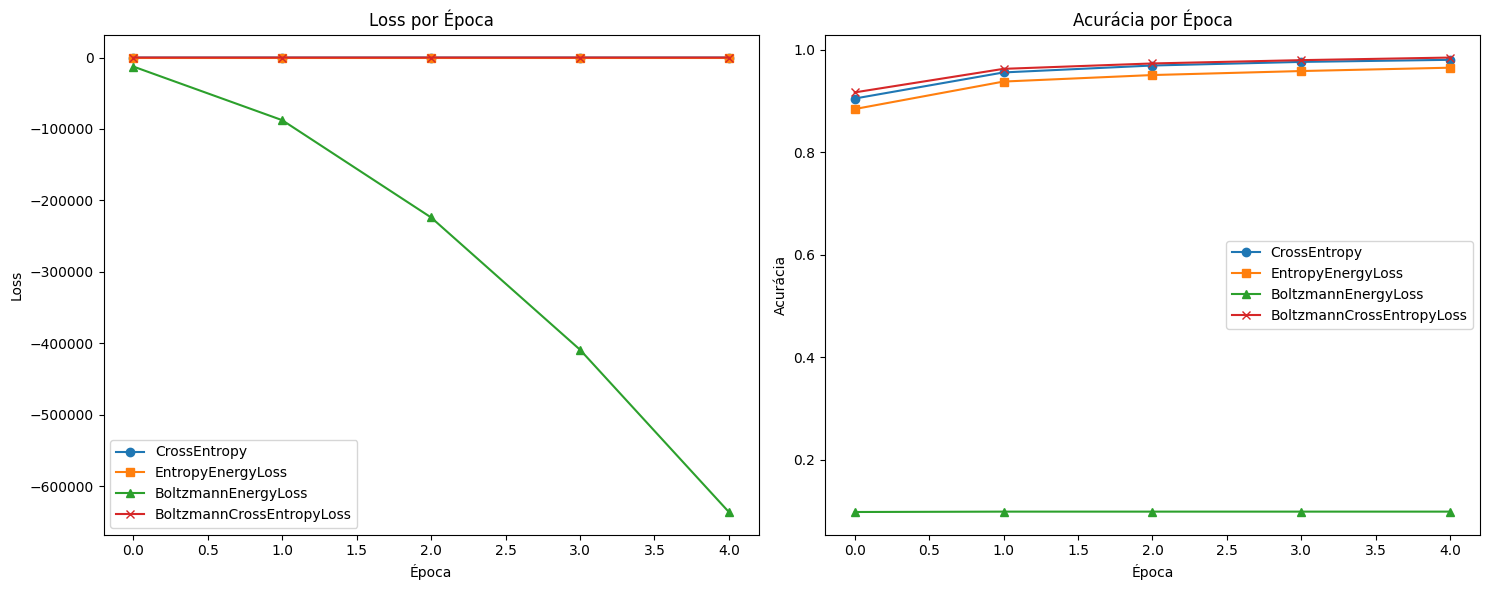

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Dataset MNIST
transform = transforms.ToTensor()
train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Modelo base
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

# Função de perda EntropyEnergyLoss (energia dissipada)
class EntropyEnergyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs, targets):
        energies = torch.exp(outputs)  # transforma logits em energias
        total_energy = torch.sum(energies, dim=1)
        correct_energy = energies[range(outputs.size(0)), targets]
        loss = correct_energy / total_energy  # queremos isso o menor possível
        return torch.mean(1 - loss)  # perda → 0 quando energia correta é dominante

# Função de perda BoltzmannEnergyLoss (com normalização)
class BoltzmannEnergyLoss(nn.Module):
    def __init__(self, temperature=1.0):
        super().__init__()
        self.T = temperature

    def forward(self, outputs, targets):
        energies = -outputs
        energies = energies - energies.max(dim=1, keepdim=True)[0]  # estabiliza numericamente

        weights = torch.softmax(-energies / self.T, dim=1)
        mean_energy = torch.sum(weights * energies, dim=1)
        correct_energy = energies[torch.arange(outputs.size(0)), targets]
        loss = mean_energy - correct_energy
        return loss.mean()

# Função de perda BoltzmannCrossEntropyLoss (versão estável, equivalente a CrossEntropy com temperatura)
class BoltzmannCrossEntropyLoss(nn.Module):
    def __init__(self, temperature=1.0):
        super().__init__()
        self.T = temperature

    def forward(self, outputs, targets):
        energies = -outputs
        energies = energies - energies.max(dim=1, keepdim=True)[0]
        logits = -energies / self.T  # logits para softmax

        log_probs = torch.log_softmax(logits, dim=1)
        loss = -log_probs[torch.arange(outputs.size(0)), targets]
        return loss.mean()

# Função de treinamento
def train(model, loss_fn, optimizer, epochs=5):
    loss_list, acc_list = [], []

    for epoch in range(epochs):
        total_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        loss_list.append(avg_loss)
        acc_list.append(accuracy)
        print(f"Época {epoch+1} | Loss: {avg_loss:.4f} | Acurácia: {accuracy*100:.2f}%")

    return loss_list, acc_list

# Treinamento CrossEntropyLoss
print("\nTreinando com CrossEntropyLoss...")
model_ce = Net()
loss_fn_ce = nn.CrossEntropyLoss()
optimizer_ce = optim.Adam(model_ce.parameters(), lr=0.001)
loss_ce, acc_ce = train(model_ce, loss_fn_ce, optimizer_ce)

# Treinamento EntropyEnergyLoss
print("\nTreinando com EntropyEnergyLoss (energia dissipada)...")
model_energy = Net()
loss_fn_energy = EntropyEnergyLoss()
optimizer_energy = optim.Adam(model_energy.parameters(), lr=0.001)
loss_energy, acc_energy = train(model_energy, loss_fn_energy, optimizer_energy)

# Treinamento BoltzmannEnergyLoss
print("\nTreinando com BoltzmannEnergyLoss (temperatura=0.5)...")
model_boltz = Net()
loss_fn_boltz = BoltzmannEnergyLoss(temperature=0.5)
optimizer_boltz = optim.Adam(model_boltz.parameters(), lr=0.001)
loss_boltz, acc_boltz = train(model_boltz, loss_fn_boltz, optimizer_boltz)

# Treinamento BoltzmannCrossEntropyLoss
print("\nTreinando com BoltzmannCrossEntropyLoss (temperatura=0.5)...")
model_boltz_ce = Net()
loss_fn_boltz_ce = BoltzmannCrossEntropyLoss(temperature=0.5)
optimizer_boltz_ce = optim.Adam(model_boltz_ce.parameters(), lr=0.001)
loss_boltz_ce, acc_boltz_ce = train(model_boltz_ce, loss_fn_boltz_ce, optimizer_boltz_ce)

# Plot comparação
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(loss_ce, label='CrossEntropy', marker='o')
plt.plot(loss_energy, label='EntropyEnergyLoss', marker='s')
plt.plot(loss_boltz, label='BoltzmannEnergyLoss', marker='^')
plt.plot(loss_boltz_ce, label='BoltzmannCrossEntropyLoss', marker='x')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_ce, label='CrossEntropy', marker='o')
plt.plot(acc_energy, label='EntropyEnergyLoss', marker='s')
plt.plot(acc_boltz, label='BoltzmannEnergyLoss', marker='^')
plt.plot(acc_boltz_ce, label='BoltzmannCrossEntropyLoss', marker='x')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()



Treinando com CrossEntropyLoss...
Época 1 | Loss: 0.3515 | Acurácia: 90.43%
Época 2 | Loss: 0.1626 | Acurácia: 95.29%
Época 3 | Loss: 0.1114 | Acurácia: 96.75%
Época 4 | Loss: 0.0834 | Acurácia: 97.58%
Época 5 | Loss: 0.0663 | Acurácia: 98.11%

Treinando com BoltzmannEnergyLoss...
Época 1 | Loss: -14380.5467 | Acurácia: 11.17%
Época 2 | Loss: -96722.7040 | Acurácia: 11.24%
Época 3 | Loss: -243624.8963 | Acurácia: 11.24%
Época 4 | Loss: -442112.8656 | Acurácia: 11.24%
Época 5 | Loss: -685451.0192 | Acurácia: 11.24%

Treinando com InverseDecayLoss...
Época 1 | Loss: 5.1307 | Acurácia: 0.04%
Época 2 | Loss: 3.3342 | Acurácia: 0.00%
Época 3 | Loss: 2.5003 | Acurácia: 0.00%
Época 4 | Loss: 2.0001 | Acurácia: 0.00%
Época 5 | Loss: 1.6667 | Acurácia: 0.00%


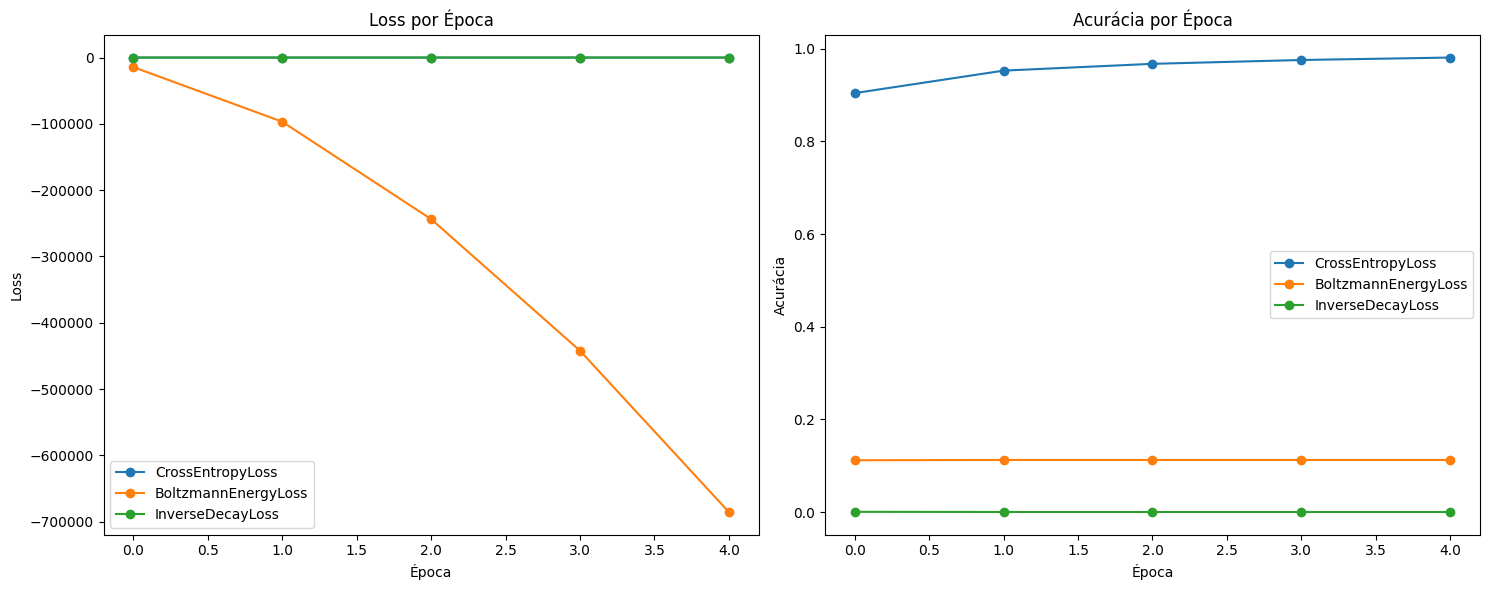

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Dataset MNIST
transform = transforms.ToTensor()
train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Modelo base
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

# Função de perda customizada: InverseDecayLoss
class InverseDecayLoss(nn.Module):
    def __init__(self, alpha=0.1, epsilon=1e-8):
        super().__init__()
        self.alpha = alpha
        self.epsilon = epsilon
        self.epoch = 0  # contador da época para decaimento

    def forward(self, outputs, targets):
        one_hot = torch.nn.functional.one_hot(targets, num_classes=outputs.size(1)).float()
        probs = torch.softmax(outputs, dim=1)
        error = torch.abs(probs - one_hot).mean(dim=1)  # erro médio por amostra
        inv_error = 1 / (error + self.epsilon)
        decay_factor = 1 / (1 + self.alpha * self.epoch)
        loss = decay_factor * inv_error.mean()
        return loss

    def set_epoch(self, epoch):
        self.epoch = epoch

# Outras funções de perda (CrossEntropy e BoltzmannEnergyLoss simplificada)
class BoltzmannEnergyLoss(nn.Module):
    def __init__(self, temperature=1.0):
        super().__init__()
        self.T = temperature

    def forward(self, outputs, targets):
        energies = -outputs
        energies = energies - energies.max(dim=1, keepdim=True)[0]
        weights = torch.softmax(-energies / self.T, dim=1)
        mean_energy = torch.sum(weights * energies, dim=1)
        correct_energy = energies[torch.arange(outputs.size(0)), targets]
        loss = mean_energy - correct_energy
        return loss.mean()

# Função de treino genérica
def train(model, loss_fn, optimizer, epochs=5):
    loss_list, acc_list = [], []

    for epoch in range(epochs):
        total_loss, correct, total = 0.0, 0, 0

        # Atualiza a época na loss se tiver método set_epoch
        if hasattr(loss_fn, 'set_epoch'):
            loss_fn.set_epoch(epoch)

        for images, labels in train_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        loss_list.append(avg_loss)
        acc_list.append(accuracy)
        print(f"Época {epoch+1} | Loss: {avg_loss:.4f} | Acurácia: {accuracy*100:.2f}%")

    return loss_list, acc_list

# Instâncias dos modelos e losses para comparação
models = {
    "CrossEntropyLoss": (Net(), nn.CrossEntropyLoss()),
    "BoltzmannEnergyLoss": (Net(), BoltzmannEnergyLoss(temperature=0.5)),
    "InverseDecayLoss": (Net(), InverseDecayLoss(alpha=0.5)),
}

results = {}

for name, (model, loss_fn) in models.items():
    print(f"\nTreinando com {name}...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_hist, acc_hist = train(model, loss_fn, optimizer, epochs=5)
    results[name] = (loss_hist, acc_hist)

# Plot comparação
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
for name, (loss_hist, _) in results.items():
    plt.plot(loss_hist, label=name, marker='o')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for name, (_, acc_hist) in results.items():
    plt.plot(acc_hist, label=name, marker='o')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


### Mais testes com outras funcoes diferenciaveis


Treinando com CrossEntropyLoss...
Época 1 | Loss: 0.3427 | Acurácia: 90.79%
Época 2 | Loss: 0.1595 | Acurácia: 95.37%
Época 3 | Loss: 0.1119 | Acurácia: 96.71%
Época 4 | Loss: 0.0846 | Acurácia: 97.50%
Época 5 | Loss: 0.0673 | Acurácia: 97.97%

Treinando com BoltzmannEnergyLoss...
Época 1 | Loss: -13656.4167 | Acurácia: 10.22%
Época 2 | Loss: -92447.6186 | Acurácia: 10.22%
Época 3 | Loss: -233420.3854 | Acurácia: 10.22%
Época 4 | Loss: -424011.8925 | Acurácia: 10.22%
Época 5 | Loss: -659476.7401 | Acurácia: 10.22%

Treinando com SqrtErrorLoss...
Época 1 | Loss: 0.1529 | Acurácia: 28.17%
Época 2 | Loss: 0.1437 | Acurácia: 28.74%
Época 3 | Loss: 0.1432 | Acurácia: 28.86%
Época 4 | Loss: 0.1429 | Acurácia: 28.92%
Época 5 | Loss: 0.1428 | Acurácia: 28.94%


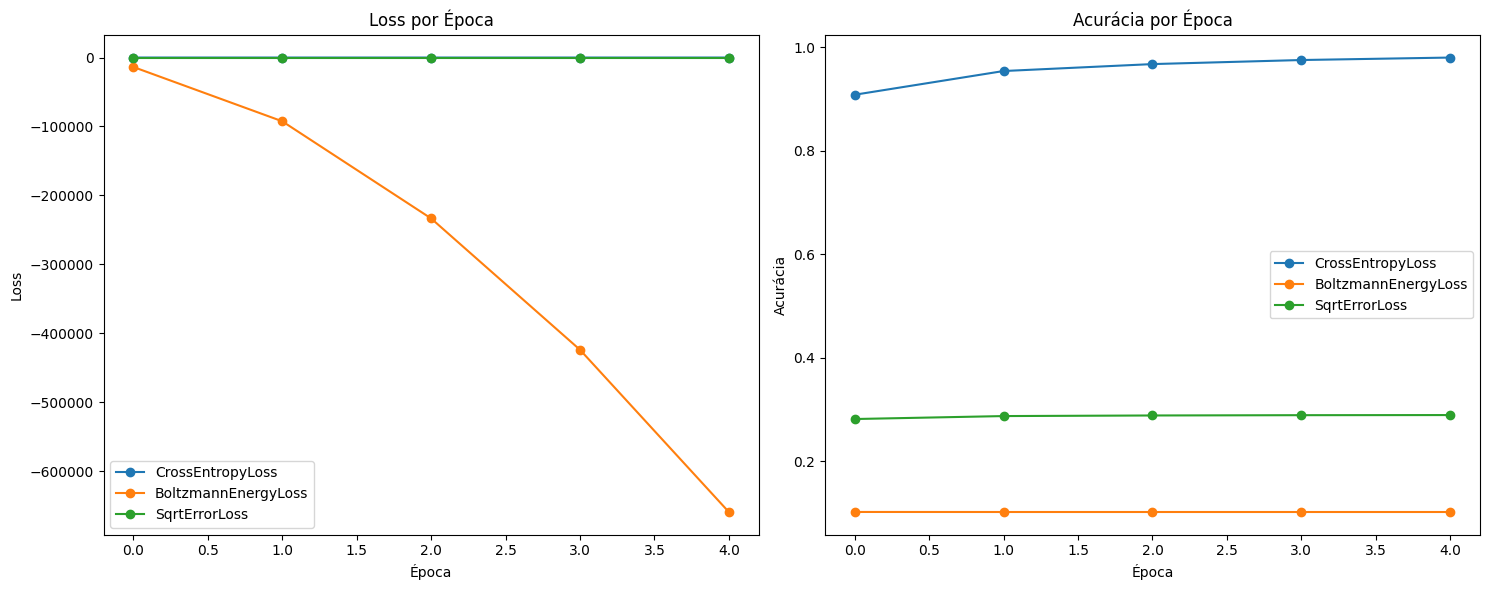

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Dataset MNIST
transform = transforms.ToTensor()
train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Modelo base
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

# Loss SqrtErrorLoss
class SqrtErrorLoss(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, outputs, targets):
        one_hot = torch.nn.functional.one_hot(targets, num_classes=outputs.size(1)).float()
        probs = torch.softmax(outputs, dim=1)
        error = torch.abs(probs - one_hot) + self.epsilon  # evitar raiz de zero
        loss = torch.sqrt(error).mean()
        return loss

# Outras losses para comparação
class BoltzmannEnergyLoss(nn.Module):
    def __init__(self, temperature=1.0):
        super().__init__()
        self.T = temperature

    def forward(self, outputs, targets):
        energies = -outputs
        energies = energies - energies.max(dim=1, keepdim=True)[0]
        weights = torch.softmax(-energies / self.T, dim=1)
        mean_energy = torch.sum(weights * energies, dim=1)
        correct_energy = energies[torch.arange(outputs.size(0)), targets]
        loss = mean_energy - correct_energy
        return loss.mean()

# Função de treino genérica
def train(model, loss_fn, optimizer, epochs=5):
    loss_list, acc_list = [], []

    for epoch in range(epochs):
        total_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        loss_list.append(avg_loss)
        acc_list.append(accuracy)
        print(f"Época {epoch+1} | Loss: {avg_loss:.4f} | Acurácia: {accuracy*100:.2f}%")

    return loss_list, acc_list

# Instâncias dos modelos e losses para comparação
models = {
    "CrossEntropyLoss": (Net(), nn.CrossEntropyLoss()),
    "BoltzmannEnergyLoss": (Net(), BoltzmannEnergyLoss(temperature=0.5)),
    "SqrtErrorLoss": (Net(), SqrtErrorLoss()),
}

results = {}

for name, (model, loss_fn) in models.items():
    print(f"\nTreinando com {name}...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_hist, acc_hist = train(model, loss_fn, optimizer, epochs=5)
    results[name] = (loss_hist, acc_hist)

# Plot comparação
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
for name, (loss_hist, _) in results.items():
    plt.plot(loss_hist, label=name, marker='o')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for name, (_, acc_hist) in results.items():
    plt.plot(acc_hist, label=name, marker='o')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


### Ajuste na raiz de x

In [44]:
import torch
import torch.nn as n
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Dataset MNIST
transform = transforms.ToTensor()
train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Modelo base
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

# Loss melhorada
class ImprovedSqrtErrorLoss(nn.Module):
    def __init__(self, epsilon=1e-8, alpha=0.05):
        super().__init__()
        self.epsilon = epsilon
        self.alpha = alpha
        self.epoch = 0

    def forward(self, outputs, targets):
        one_hot = torch.nn.functional.one_hot(targets, num_classes=outputs.size(1)).float()
        probs = torch.softmax(outputs, dim=1)
        error = torch.abs(probs - one_hot) + self.epsilon

        smooth_error = torch.sqrt(error) + torch.log(error + 1)
        decay = 1 / (1 + self.alpha * self.epoch)

        loss = decay * smooth_error.mean()
        return loss

    def set_epoch(self, epoch):
        self.epoch = epoch

# Função de treino genérica
def train(model, loss_fn, optimizer, epochs=5):
    loss_list, acc_list = [], []

    for epoch in range(epochs):
        loss_fn.set_epoch(epoch)  # Atualiza fator decaimento
        total_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        loss_list.append(avg_loss)
        acc_list.append(accuracy)
        print(f"Época {epoch+1} | Loss: {avg_loss:.4f} | Acurácia: {accuracy*100:.2f}%")

    return loss_list, acc_list

# Instanciar modelo, loss e otimizador
model = Net()
loss_fn = ImprovedSqrtErrorLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Rodar treino
train(model, loss_fn, optimizer, epochs=5)


Época 1 | Loss: 0.3087 | Acurácia: 9.92%
Época 2 | Loss: 0.2907 | Acurácia: 9.87%
Época 3 | Loss: 0.2775 | Acurácia: 9.87%
Época 4 | Loss: 0.2655 | Acurácia: 9.87%
Época 5 | Loss: 0.2544 | Acurácia: 9.87%


([0.3086655062398931,
  0.2907418345909383,
  0.2775310314000288,
  0.26546435796820533,
  0.25440801321062195],
 [0.09923333333333334,
  0.09871666666666666,
  0.09871666666666666,
  0.09871666666666666,
  0.09871666666666666])

### Ajustando p potencia de 1.5

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Dataset MNIST
transform = transforms.ToTensor()
train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Modelo simples
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

# Função de perda: erro elevado à potência 1.5
class PowerErrorLoss(nn.Module):
    def __init__(self, epsilon=1e-8, alpha=0.05, power=1.5):
        super().__init__()
        self.epsilon = epsilon
        self.alpha = alpha
        self.epoch = 0
        self.power = power

    def forward(self, outputs, targets):
        one_hot = torch.nn.functional.one_hot(targets, num_classes=outputs.size(1)).float()
        probs = torch.softmax(outputs, dim=1)
        error = torch.abs(probs - one_hot) + self.epsilon
        powered_error = error.pow(self.power)
        decay = 1 / (1 + self.alpha * self.epoch)
        loss = decay * powered_error.mean()
        return loss

    def set_epoch(self, epoch):
        self.epoch = epoch

# Função de treino
def train(model, loss_fn, optimizer, epochs=5):
    loss_list, acc_list = [], []
    for epoch in range(epochs):
        loss_fn.set_epoch(epoch)
        total_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        loss_list.append(avg_loss)
        acc_list.append(accuracy)
        print(f"Época {epoch+1} | Loss: {avg_loss:.4f} | Acurácia: {accuracy*100:.2f}%")

    return loss_list, acc_list

# Instanciar modelo, loss e otimizador
model = Net()
loss_fn = PowerErrorLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Treinar
train(model, loss_fn, optimizer, epochs=5)


Época 1 | Loss: 0.0203 | Acurácia: 90.19%
Época 2 | Loss: 0.0099 | Acurácia: 94.61%
Época 3 | Loss: 0.0072 | Acurácia: 95.91%
Época 4 | Loss: 0.0055 | Acurácia: 96.78%
Época 5 | Loss: 0.0044 | Acurácia: 97.34%


([0.020321760365098064,
  0.00991336203630525,
  0.007168382158014438,
  0.005505708380346509,
  0.00437773569484522],
 [0.90185, 0.9461, 0.9590833333333333, 0.9678333333333333, 0.9734])